In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

e:\Bootcamp\DS_Grupo3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'train_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df = pd.read_csv(file_path)
df.head()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'test_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [3]:
df_train = df

y_train = df_train['stroke']
X_train = df_train.drop(['stroke'], axis=1).astype(int)

y_test = df_test['stroke']
X_test = df_test.drop(['stroke'], axis=1).astype(int)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [4]:
X = X_train
y = y_train
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_seed': 1337,
        'verbose': 0
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
        
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > 0.5).astype(int)  # Ajusta el umbral aquí si es necesario
        
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
    
    return sum(f1s) / len(f1s)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)

[I 2024-10-14 17:49:44,668] A new study created in memory with name: no-name-672240e9-2cb8-4d91-838e-ea0d6d01daa9
[I 2024-10-14 17:49:51,665] Trial 0 finished with value: 0.7568082960896898 and parameters: {'iterations': 350, 'learning_rate': 0.1104450957356514, 'depth': 9, 'l2_leaf_reg': 0.5686216063002886, 'border_count': 22}. Best is trial 0 with value: 0.7568082960896898.
[I 2024-10-14 17:50:04,012] Trial 1 finished with value: 0.7558210004286844 and parameters: {'iterations': 771, 'learning_rate': 0.09129877309127254, 'depth': 8, 'l2_leaf_reg': 0.00036528912255203355, 'border_count': 108}. Best is trial 0 with value: 0.7568082960896898.
[I 2024-10-14 17:50:15,402] Trial 2 finished with value: 0.7563397270688246 and parameters: {'iterations': 782, 'learning_rate': 0.23850698740040935, 'depth': 6, 'l2_leaf_reg': 6.580114575707037, 'border_count': 71}. Best is trial 0 with value: 0.7568082960896898.
[I 2024-10-14 17:50:29,995] Trial 3 finished with value: 0.7563778625006095 and param

0:	learn: 0.6277036	total: 3.71ms	remaining: 1.91s
1:	learn: 0.5603371	total: 8.45ms	remaining: 2.17s
2:	learn: 0.5420145	total: 10.8ms	remaining: 1.83s
3:	learn: 0.5336701	total: 12.7ms	remaining: 1.62s
4:	learn: 0.5263887	total: 15.4ms	remaining: 1.57s
5:	learn: 0.5098693	total: 20ms	remaining: 1.7s
6:	learn: 0.4999778	total: 23.8ms	remaining: 1.73s
7:	learn: 0.4969137	total: 26.1ms	remaining: 1.66s
8:	learn: 0.4952128	total: 28.3ms	remaining: 1.59s
9:	learn: 0.4894756	total: 32.2ms	remaining: 1.63s
10:	learn: 0.4884337	total: 34.5ms	remaining: 1.58s
11:	learn: 0.4877178	total: 36.5ms	remaining: 1.53s
12:	learn: 0.4868135	total: 38.8ms	remaining: 1.5s
13:	learn: 0.4864049	total: 40.9ms	remaining: 1.46s
14:	learn: 0.4836351	total: 44.6ms	remaining: 1.49s
15:	learn: 0.4818038	total: 48.5ms	remaining: 1.51s
16:	learn: 0.4815823	total: 50.9ms	remaining: 1.49s
17:	learn: 0.4809161	total: 54.5ms	remaining: 1.5s
18:	learn: 0.4808145	total: 56.6ms	remaining: 1.48s
19:	learn: 0.4805897	total:

In [27]:
'''
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
final_model = CatBoostClassifier(**best_params, class_weights = class_weights_dict)
final_model.fit(X, y)
'''

"\nclass_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)\nclass_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}\nfinal_model = CatBoostClassifier(**best_params, class_weights = class_weights_dict)\nfinal_model.fit(X, y)\n"

In [15]:
y_prob = final_model.predict_proba(X_test)[:, 1]

optimal_threshold = 0.5  # Ajusta este umbral según sea necesario
y_pred = (y_prob > optimal_threshold).astype(int)

accuracy_final = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

Precisión del modelo: 0.7392176529588766


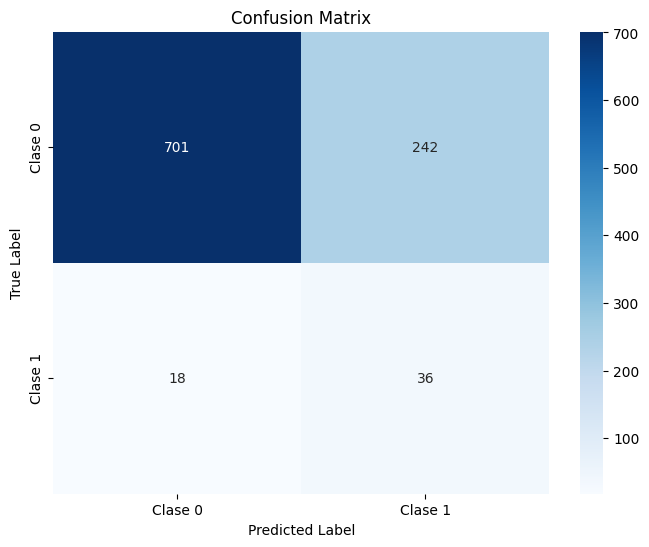

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



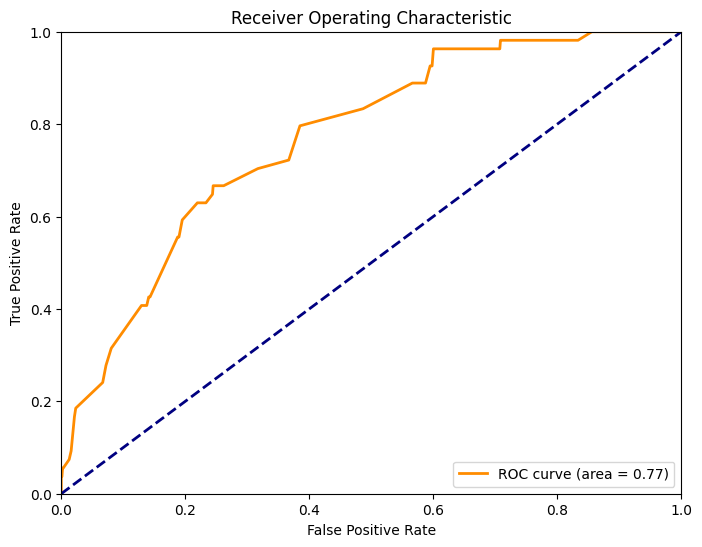

In [16]:
plt.figure(figsize=(8,6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
# Separar las características y la variable objetivo del conjunto de test
X_test_new = df_test.drop(['stroke'], axis=1).astype(int)
y_test_new = df_test['stroke']

# Predecir con el modelo final
y_pred_test_new = final_model.predict(X_test_new)
accuracy_test_new = accuracy_score(y_test_new, y_pred_test_new)

# Evaluar el modelo
conf_matrix_test_new = confusion_matrix(y_test_new, y_pred_test_new)
class_report_test_new = classification_report(y_test_new, y_pred_test_new)

# Mostrar resultados
print(f"Precisión del modelo en el conjunto de test: {accuracy_test_new}")
print("Matriz de confusión:\n", conf_matrix_test_new)
print("Reporte de clasificación:\n", class_report_test_new)

Precisión del modelo en el conjunto de test: 0.7392176529588766
Matriz de confusión:
 [[701 242]
 [ 18  36]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



Precisión del modelo: 0.7392176529588766


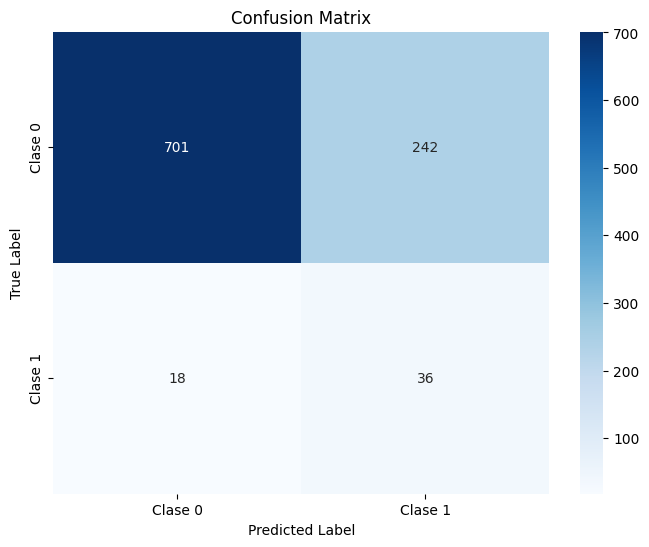

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



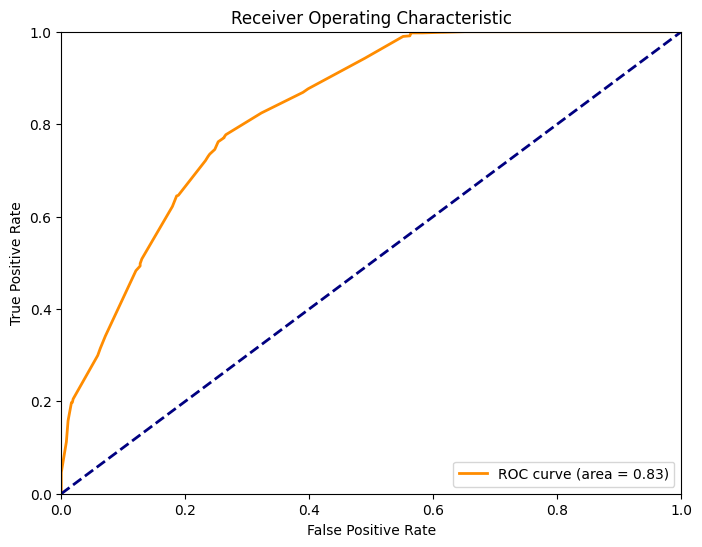

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_new, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_test_new}")
plt.show()
print("Reporte de clasificación:\n", class_report_test_new)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()